# CMSC 636, HW4: Deep Belief Network on MNIST

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

from types import SimpleNamespace

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


## Load MNIST

In [2]:
# load mnist dataset with labels encoded as one-hot vectors
class Dataset():
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.epochs = 0

    def shuffle(self):
        perm = np.arange(self.data[0].shape[0])
        np.random.shuffle(perm)
        self.data = tuple(datai[perm] for datai in self.data)
    
    def next_batch(self, batch_size):
        start = self.index
        end = self.index + batch_size
        if end > self.data[0].shape[0]:
            self.epochs += 1
            self.shuffle()
            self.index, start = 0, 0
            end = batch_size
        self.index = end
        return tuple(datai[start:end, ...] for datai in self.data)
            
def load_mnist():
    def preprocess(data, labels, num_classes):
        # flatten images
        data = data.astype(np.float32)/255.0
        data = np.reshape(data, [data.shape[0], -1])
        # one hot encoding
        num_labels = labels.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels.ravel()] = 1
        return data, labels_one_hot
    train, test = tf.keras.datasets.mnist.load_data()
    train = preprocess(train[0], train[1], 10)
    test = preprocess(test[0], test[1], 10)
    return SimpleNamespace(
        train=Dataset(train), 
        test=Dataset(test))
mnist = load_mnist()

## Model definition

In [3]:
sess = tf.InteractiveSession()

In [4]:
def bernoulli_sample_tf(x):
    ''' sample from bernoulli distribution given a tf matrix '''
    in_shape= x.get_shape().as_list()
    uniform_samp = tf.random_uniform(shape=(in_shape[0], in_shape[1]), minval=0.0, maxval=1.0) 
    return tf.to_float(tf.greater(x, uniform_samp))

Implement the contrastive divergence update rule for the rbm, using a mini-batch of $ M $ samples:

$ W←W+αΔW $ <br>
$ b←b+αΔb $ <br>
$ c←c+αΔc $ <br>

Where:

* <p> $W ∈ R^{V×H}, b ∈ R^{H}, c ∈ R^{V}$ <p>

* <p> $X∈R^{M×V}$, is the matrix composed by the training samples in the mini-batch. Each row of $X$ is a training sample <p>

* <p> $ΔW=\frac{1}{M}(X^{T}h(x)−X^{T}_{s}h(X_{s}))$ <p>

* <p> $Δb=mean((h(X)−h(X_{s})))$ <p>

* <p> $Δc=mean((X−X_{s}))$ <p>

* <p> $h(X)=σ(XW+b)$ <p>
    
* <p> $ σ(x)=\frac{1}{1+exp(−x)}$ <p>

Note: The model uses Bernoulli visible and hidden layers

In [5]:
n_inputs = 28*28         # Complete: number of input units (i.e. V)
n_hidden = [20, 20]    # number of hidden units (i.e. H), try different values
batch_size = 500         # number of samples on the mini-batch (i.e. M)

k = 5          #Try different values 
alpha = 0.1  #Try different values

In [6]:
class rbm_model(object):
    def __init__(self, n_inputs, n_hidden, w_stddev=0.1, k = 1, alpha = 0.001, batch_size = 500):
        ''''Define the parameters of the rbm model'''
        self.W = tf.Variable(tf.zeros([n_inputs, n_hidden])) # Complete: weight matrix for the rbm model
        self.b = tf.Variable(tf.zeros([batch_size, n_hidden]))# # Complete: b vector for the rbm model
        self.c = tf.Variable(tf.zeros([batch_size, n_inputs])) # Complete: c vector for the rbm model
        self.k = k
        self.alpha = alpha
        self.n_hidden = n_hidden
        self.batch_size = batch_size
    
    def __call__(self, X):
        '''Model function definition'''
        
        # K gibbs sampling: obtain a set of samples Xs by performing K-gibbs sampling steps
        Xs = X
        for i in range(self.k):
            h_prob = tf.sigmoid(tf.matmul(Xs, self.W) + self.b)
            hs = bernoulli_sample_tf(h_prob)
            x_prob = tf.sigmoid(tf.matmul(hs, tf.transpose(self.W)) + self.c)
            Xs = bernoulli_sample_tf(x_prob)
        
        # Parameter update:
        h_X = tf.sigmoid(tf.matmul(X, self.W) + self.b)   # Complete: compute h(X)
        h_Xs = tf.sigmoid(tf.matmul(Xs, self.W) + self.b) # Complete: compute h(Xs)
        
        dW = 1/batch_size * (tf.matmul(tf.transpose(X),h_X) - tf.matmul(tf.transpose(Xs),h_Xs))   
        # Complete: follow update equations
     
        
        db = 1/k * (h_X - h_Xs)   # Complete: follow update equations
        dc = 1/k * (X - Xs)   # Complete: follow update equations

        
        op_W= self.W.assign_add( self.alpha*dW )
        op_b= self.b.assign_add( self.alpha*db )
        op_c= self.c.assign_add( self.alpha*dc )
        
        return x_prob, h_X
        
layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)


In [7]:
def method_1():
    num_steps= 10000 # try different values
    n_logging = 500  # try different values

    for step in range(num_steps):
        # -------- train RBM -----#
        batch_x, _= mnist.train.next_batch(batch_size)
        x_g, h1_x = layer0(batch_x)




        #  ------- logging -------
        if step%n_logging == 0:
            clear_output()
            print('Samples generated starting from given X')

            x_gaux = np.reshape(x_g, [-1,28,28,1])        
            plt.figure(1)
            for i in range(2*4):
                plt.subplot(241 + i)
                plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
            plt.show()

            print('Samples generated from random H1')


            # random samples from RBM model starting with random h1 samples
            hst = tf.random.uniform(shape=(layer0.batch_size, layer0.n_hidden), minval=0, maxval=1)

            for i in range(layer0.k): 
                Xst_prob = tf.sigmoid(tf.matmul(hst, tf.transpose(layer0.W)) + layer0.c)
                Xst = bernoulli_sample_tf(Xst_prob)
                hst_prob = tf.sigmoid(tf.matmul(Xst, layer0.W) + layer0.b)
                hst = bernoulli_sample_tf(hst_prob)
            x_g = tf.sigmoid(tf.matmul(hst, tf.transpose(layer0.W)) + layer0.c) # X generated from random h1


            x_gaux = np.reshape(x_g, [-1,28,28,1])

            plt.figure(2)
            for i in range(2*4):
                plt.subplot(241 + i)
                plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
            plt.show()

In [8]:
def method_2():
    num_steps= 10000 # try different values
    n_logging = 500  # try different values

    for step in range(num_steps):
        # -------- train RBM -----#
        batch_x, _= mnist.train.next_batch(batch_size)
        x_g, h1_x = layer0(batch_x)
        h1s_prob, h2_h1 = layer1(h1_x)
        x_g = tf.sigmoid(tf.matmul(h1s_prob, tf.transpose(layer0.W)) + layer0.c) # samples given X while training second RBM

        #  ------- logging -------
        if step%n_logging == 0:
            clear_output()
            print('Samples generated starting from given X')
            x_gaux = np.reshape(x_g, [-1,28,28,1])

            plt.figure(1)
            for i in range(2*4):
                plt.subplot(241 + i)
                plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
            plt.show()

            print('Samples generated from random H2')


            # random samples from RBM model starting with random h2 samples
            h2st = tf.random.uniform(shape=(layer1.batch_size, layer1.n_hidden), minval=0, maxval=1)
            for i in range(layer1.k): 
                h1st_prob = tf.sigmoid(tf.matmul(h2st, tf.transpose(layer1.W)) + layer1.c)
                h1st = bernoulli_sample_tf(h1st_prob)
                h2st_prob = tf.sigmoid(tf.matmul(h1st, layer1.W) + layer1.b)
                h2st = bernoulli_sample_tf(h2st_prob)
            x_g = tf.sigmoid(tf.matmul(h1st, tf.transpose(layer0.W)) + layer0.c) # X generated from random h2

            x_gaux = np.reshape(x_g, [-1,28,28,1])

            plt.figure(2)
            for i in range(2*4):
                plt.subplot(241 + i)
                plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
            plt.show()

Samples generated starting from given X


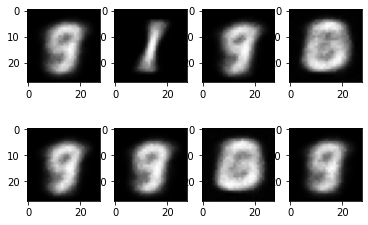

Samples generated from random H1


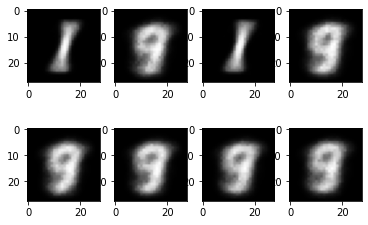

In [9]:
method_1()

Samples generated starting from given X


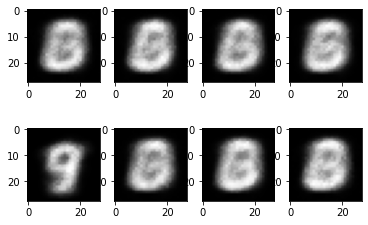

Samples generated from random H2


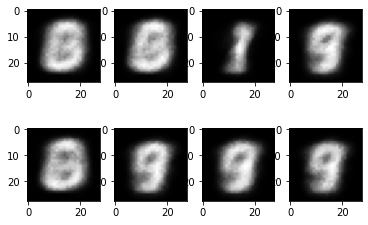

In [10]:
method_2()

Samples generated starting from given X


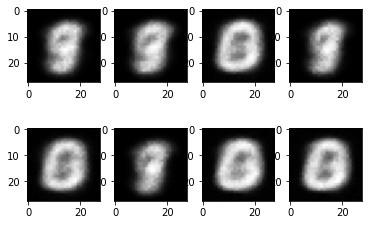

Samples generated from random H1


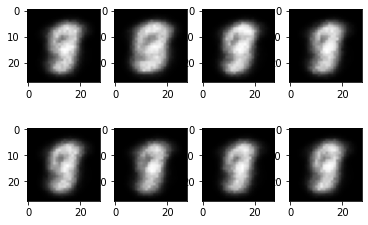

In [11]:
n_hidden = [30, 30]    # number of hidden units (i.e. H), try different values
k = 5          #Try different values 
alpha = 0.1  #Try different values

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

method_1()

Samples generated starting from given X


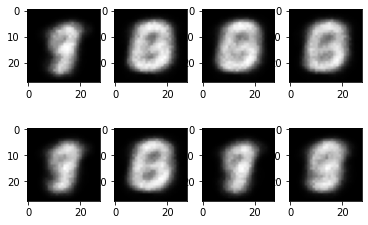

Samples generated from random H2


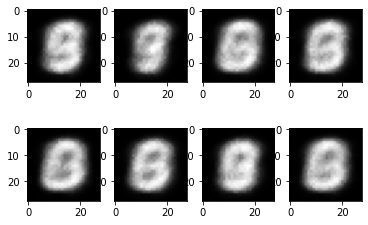

In [12]:
method_2()

Samples generated starting from given X


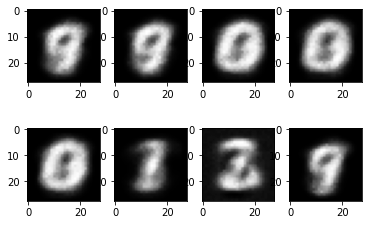

Samples generated from random H1


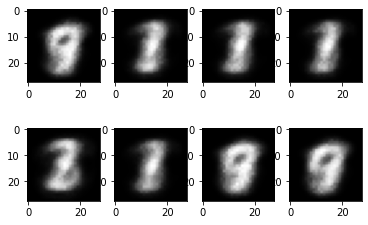

In [13]:
n_hidden = [40, 40]    # number of hidden units (i.e. H), try different values
k = 5          #Try different values 
alpha = 0.1  #Try different values

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

method_1()

Samples generated starting from given X


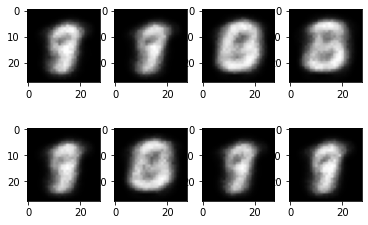

Samples generated from random H2


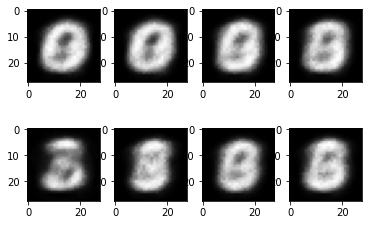

In [14]:
method_2()

Samples generated starting from given X


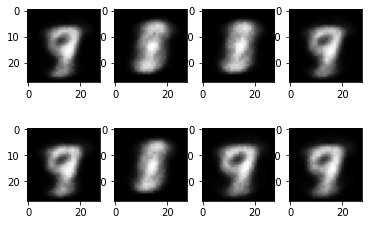

Samples generated from random H1


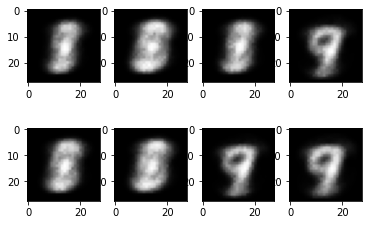

In [15]:
n_hidden = [50, 50]    # number of hidden units (i.e. H), try different values
k = 5          #Try different values 
alpha = 0.1  #Try different values

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

method_1()

Samples generated starting from given X


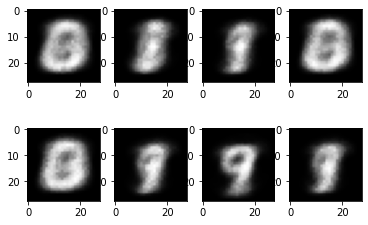

Samples generated from random H2


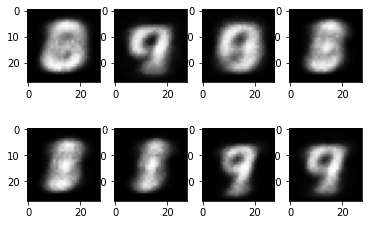

In [16]:
method_2()

Samples generated starting from given X


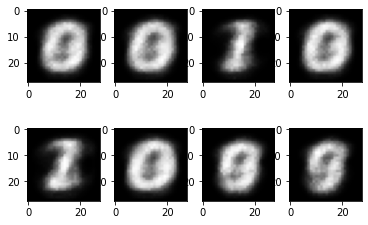

Samples generated from random H1


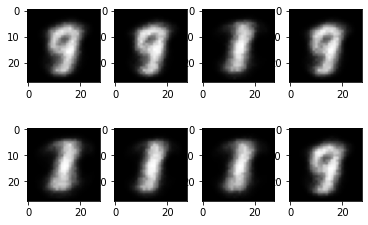

In [17]:
n_hidden = [100, 100]    # number of hidden units (i.e. H), try different values
k = 5          #Try different values 
alpha = 0.1  #Try different values

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

method_1()

Samples generated starting from given X


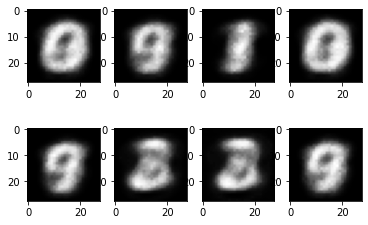

Samples generated from random H2


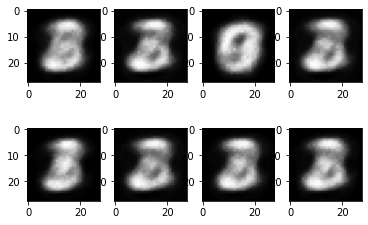

In [18]:
method_2()

Samples generated starting from given X


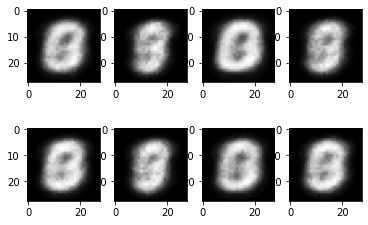

Samples generated from random H1


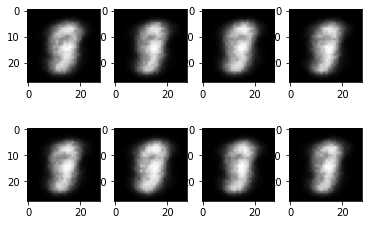

In [19]:
n_hidden = [144, 20]    # number of hidden units (i.e. H), try different values
k = 5          #Try different values 
alpha = 0.1  #Try different values

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

method_1()

Samples generated starting from given X


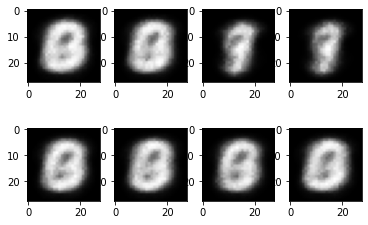

Samples generated from random H2


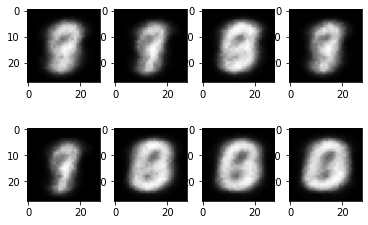

In [20]:
method_2()

Samples generated starting from given X


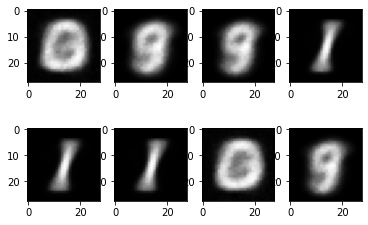

Samples generated from random H1


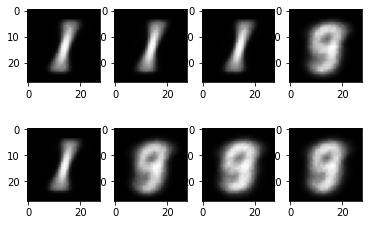

In [21]:
n_hidden = [20, 20]    # number of hidden units (i.e. H), try different values
k = 5          #Try different values 
alpha = 0.05  #Try different values

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

method_1()

Samples generated starting from given X


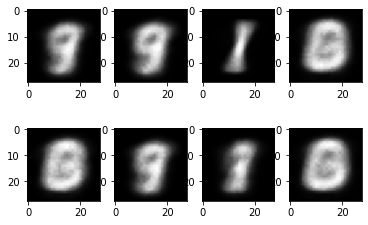

Samples generated from random H2


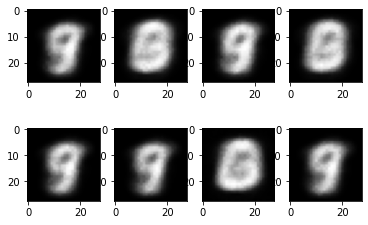

In [22]:
method_2()

Samples generated starting from given X


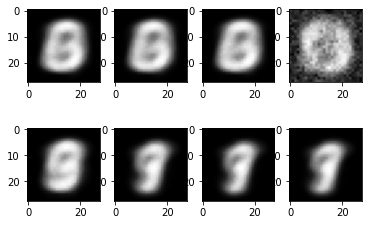

Samples generated from random H1


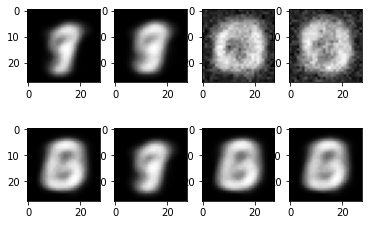

In [23]:
n_hidden = [20, 20]    # number of hidden units (i.e. H), try different values
k = 5          #Try different values 
alpha = 0.01  #Try different values

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

method_1()

Samples generated starting from given X


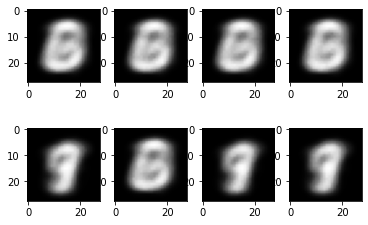

Samples generated from random H2


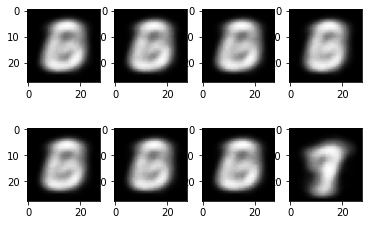

In [24]:
method_2()

Samples generated starting from given X


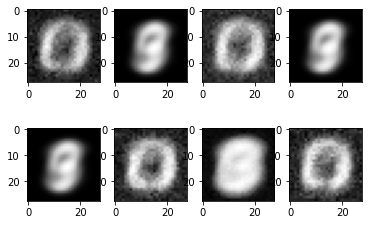

Samples generated from random H1


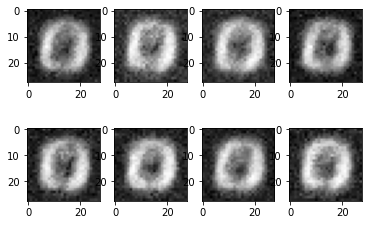

In [25]:
n_hidden = [20, 20]    # number of hidden units (i.e. H), try different values
k = 5          #Try different values 
alpha = 0.001  #Try different values

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

method_1()

Samples generated starting from given X


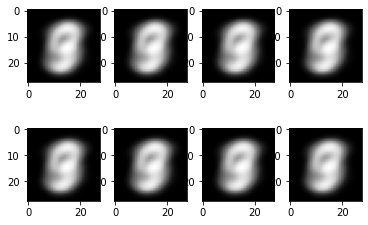

Samples generated from random H2


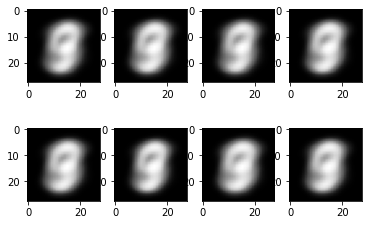

In [26]:
method_2()

Samples generated starting from given X


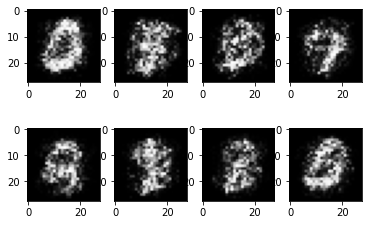

Samples generated from random H1


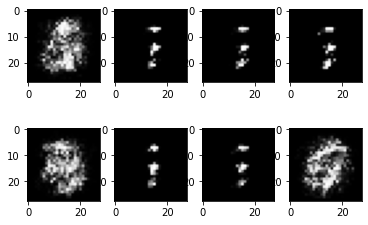

In [27]:
n_hidden = [20, 20]    # number of hidden units (i.e. H), try different values
k = 5          #Try different values 
alpha = 10  #Try different values

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

method_1()

Samples generated starting from given X


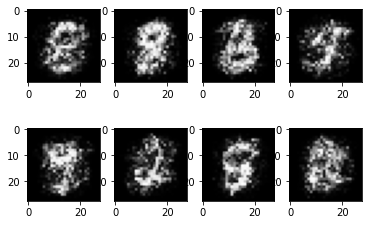

Samples generated from random H2


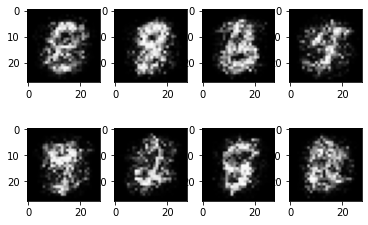

In [28]:
method_2()

Samples generated starting from given X


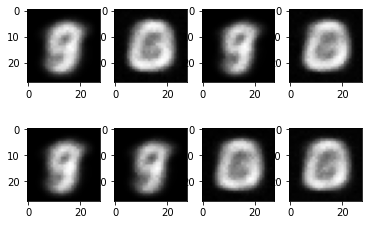

Samples generated from random H1


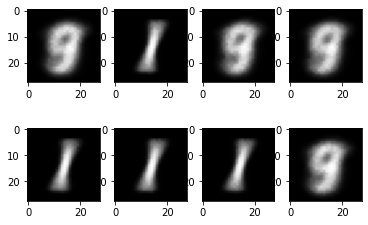

In [29]:
n_hidden = [20, 20]    # number of hidden units (i.e. H), try different values
k = 10          #Try different values 
alpha = 0.1  #Try different values

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

method_1()

Samples generated starting from given X


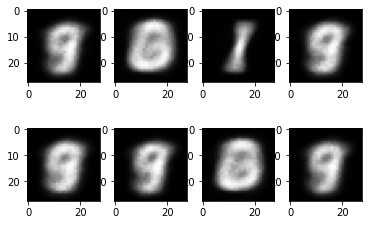

Samples generated from random H2


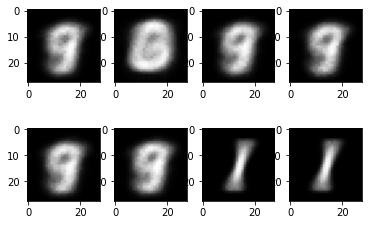

In [30]:
method_2()

Samples generated starting from given X


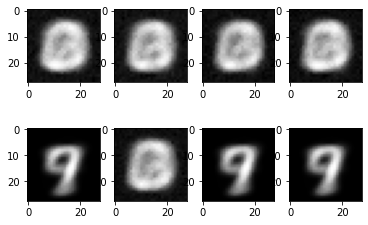

Samples generated from random H1


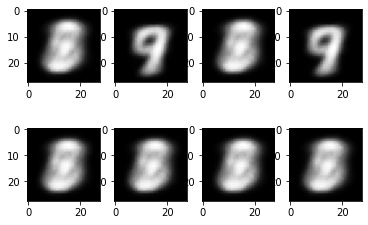

In [31]:
n_hidden = [20, 20]    # number of hidden units (i.e. H), try different values
k = 100          #Try different values 
alpha = 0.1  #Try different values

layer0 = rbm_model(n_inputs = n_inputs, n_hidden = n_hidden[0], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)
layer1 = rbm_model(n_inputs = n_hidden[0], n_hidden = n_hidden[1], w_stddev=0.1, k = k, alpha = alpha, batch_size = batch_size)

method_1()

Samples generated starting from given X


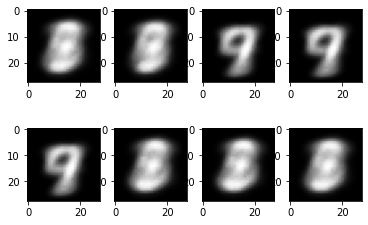

Samples generated from random H2


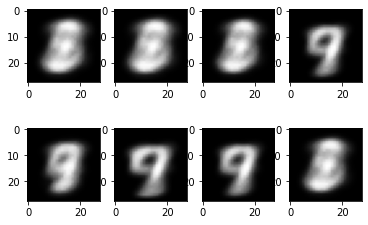

In [32]:
method_2()